In [1]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
#%matplotlib notebook

In [38]:
fileIn = "/chr19_2000_sorted_crossover_only.tsv"


In [3]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [4]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [5]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [6]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return([testChr[0],res[0]])

In [7]:
def calc_single_dist(x,rbp):
    d,h0,h1,h2,th = x
    
    r = rbp*d
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [8]:
def single_chr_obj_fun(x_,arr):
    rbp= x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [9]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [10]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [11]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [12]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [13]:
def combine_across_individuals_and_replicates(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    numReplicates = len(test['replicate'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/(numSamples*numReplicates)
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [39]:
df = pd.read_csv(fileIn,delimiter='\t')

In [40]:
df = pd.read_csv(fileIn,delimiter='\t')
df = df.loc[ df['chromosome'] != 'X']
df = df.astype({'chromosome':'int64'})

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [41]:
df

,Unnamed: 0,sample,replicate,chromosome,h_0,h_1,h_2,total,h_0_frac,h_1_frac,h_2_frac,H
0,1,1,1,19,27813995,359141,2540,28175676,0.987163,0.012746,0.000090,0.006463
1,2,1,1,19,27814006,359117,2552,28175675,0.987164,0.012746,0.000091,0.006463
2,3,1,1,19,27813945,359237,2492,28175674,0.987162,0.012750,0.000088,0.006463
3,4,1,1,19,27813972,359181,2520,28175673,0.987163,0.012748,0.000089,0.006463
4,5,1,1,19,27813986,359151,2535,28175672,0.987163,0.012747,0.000090,0.006463
...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1996,10,100,19,27795066,376847,1768,28173681,0.986561,0.013376,0.000063,0.006751
1999996,1997,10,100,19,27795138,376701,1841,28173680,0.986564,0.013371,0.000065,0.006751
1999997,1998,10,100,19,27795037,376901,1741,28173679,0.986560,0.013378,0.000062,0.006751
1999998,1999,10,100,19,27795036,376901,1741,28173678,0.986560,0.013378,0.000062,0.006751


In [35]:
modelTruth = [0.00144168 for d in list(range(0,2000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
modelEstimatedChr19CombinedReps =  [0.0014578208923336777 for d in list(range(0,2000))]
#we won't use this below, so just make them equal for now:
modelEstimatedChr19WithGC = [rho(0.0014578211661126998,0.0010329106648468952, 33.196417210391864,d+1)/(d+1) for d in list(range(0,2000))]


##### Here we are trying a single iteration

In [27]:
#testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==12) & (df['sample']==5)& (df['Unnamed: 0']<=2000)] 

testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==20) & (df['Unnamed: 0']<=2000)]
testChr = testChr.iloc[:,[0,4,5,6,11]].to_numpy()

In [42]:
jobs = [[x+1,testChr[x]] for x in list(range(0,1000))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)
thisResOneInd = [x[1] for x in thisResOneInd]

In [29]:
print(thisResOneInd)

[1e-07, 0.06366597398679458, 1e-07, 0.026002748498540614, 0.017208339941395333, 0.01834787441406795, 0.01926184550781795, 1e-07, 0.01582182089232852, 0.020269465682988846, 0.004657532159422463, 0.0057045840615059466, 0.004821074830537288, 0.00891778724365507, 0.004486368552397316, 0.006048605523905903, 1e-07, 0.011639194763161765, 0.003238148965454784, 0.007437779314425335, 0.0059451498142256065, 0.00017260624618526006, 0.004260003988381968, 0.004333822626362055, 1e-07, 0.004945402386858807, 1e-07, 0.004681293082084998, 0.005796792001341408, 0.0021661622335769236, 0.0026993177373858825, 0.0034402784396840858, 0.003410039199637684, 0.0013404048882871865, 0.0016594569685555362, 0.001265934097289698, 0.002007562960434642, 1e-07, 0.002791553614807811, 0.0028133123792641493, 0.005310913012315207, 0.0027668826202385754, 0.0007218448349000727, 0.002117927338425506, 0.002940666662213458, 0.002499644384517302, 0.000566358065796069, 0.002601085755538258, 0.002649569523619923, 1e-07, 0.0019921149

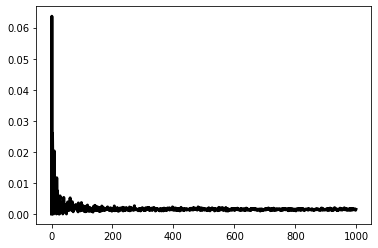

In [44]:
plt.plot( thisResOneInd,"k",linewidth=3)
plt.show()

Here combining across individuals to get an estimate of Rho/d (r/bp) for each distance  

In [47]:
testPooled = df.loc[(df['chromosome']==19) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [48]:
jobs = [[x+1,testPooled[x]] for x in list(range(1000))]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_dist,jobs)
thisRes = [x[1] for x in thisRes]

IndexError: invalid index to scalar variable.

In [49]:
print(thisRes)

[0.0341563577232522, 0.016919256761556364, 0.010724903268300853, 0.008003781809885426, 0.007680873288724077, 0.00555337762172212, 0.006070667504122601, 0.004951387048341207, 0.004418878048707419, 0.004948343223722233, 0.004025698376467572, 0.0038465247062464854, 0.003761017281912392, 0.00370496972561019, 0.0036643300532610487, 0.0029534828540866403, 0.003377406774414594, 0.003071184920119557, 0.002963449570443262, 0.0029555997532568243, 0.00257152862208663, 0.0025929955917365225, 0.0027014475559704637, 0.0023596967412831886, 0.002811105298437923, 0.0026042890656253295, 0.0024610812942498063, 0.0024996669128424793, 0.0024255230448400602, 0.0024537980370335907, 0.002369389672019825, 0.002491396522598925, 0.0023108125091559554, 0.002251758497222324, 0.0021970685393459467, 0.0021138797422044606, 0.0020705206265919543, 0.0023299452065855264, 0.002073199885447197, 0.0021342245874769353, 0.0021239491783135267, 0.0022116479270935063, 0.0019711114515297743, 0.0021100286540182956, 0.002110193280

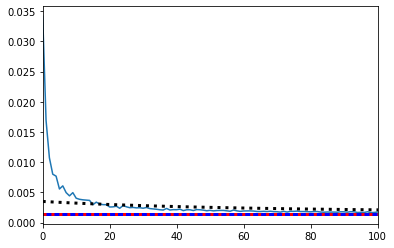

In [50]:
plt.plot([x[1] for x in thisRes])
plt.plot(modelTruth,"b",linewidth=3)
#plt.plot(modelConstant,"y",linewidth=3)
#plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"r:",linewidth=3)
plt.plot(modelEstimatedChr19WithGC,"k:",linewidth=3)
plt.xlim([0,100])
plt.show()